SAM-2
===

 * Paper: https://arxiv.org/abs/2408.00714

![SAM-2 overview](../assets/sam2-overview.png)

```bash
pip install torch torchvision
pip install matplotlib
pip install supervision
```

```bash
git clone https://github.com/facebookresearch/sam2.git && cd sam2
# installation without CUDA
SAM2_BUILD_CUDA=0 pip install -e ".[notebooks]"
````

In [1]:
import os
import numpy as np
from PIL import Image
import supervision as sv
import matplotlib.pyplot as plt
import torch
import torchvision

from sam2.sam2_image_predictor import SAM2ImagePredictor

predictor = SAM2ImagePredictor.from_pretrained(
    "facebook/sam2-hiera-large"
)

In [2]:
image_path = "../samples/plants.jpg"
image = Image.open(image_path).convert("RGB")
input_points = np.array([(650, 200)])

with torch.inference_mode():
    predictor.set_image(image)
    masks, scores, raw_logits = predictor.predict(
        point_coords=input_points,
        point_labels=[1],
    )

print("masks:", masks.shape)
print("scores:", scores.shape)
print("raw_logits:", raw_logits.shape)

masks: (3, 1137, 1068)
scores: (3,)
raw_logits: (3, 256, 256)


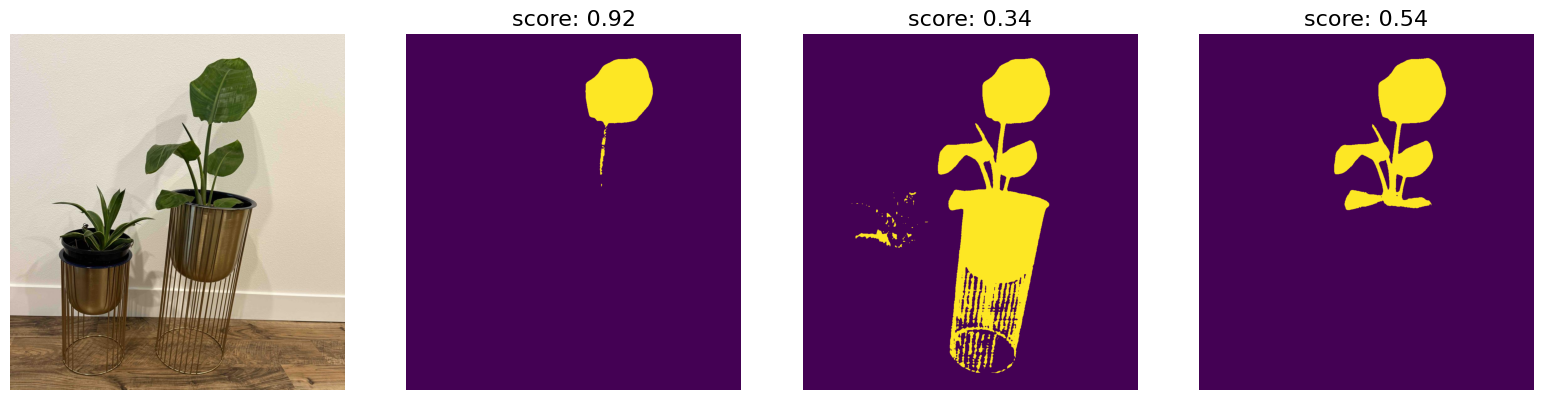

In [3]:
n = len(masks)
fig, axes = plt.subplots(1, n + 1, figsize=(4 * (n + 1), 4))

axes[0].imshow(image)
for i in range(n):
    axes[i + 1].imshow(masks[i])
    axes[i + 1].set_title(f"score: {scores[i]:.2f}", fontsize=16)
[ax.axis("off") for ax in axes]
plt.tight_layout()
plt.show()

In [4]:
scores

array([0.9195415, 0.3367977, 0.5416123], dtype=float32)

In [5]:
from PIL import ImageDraw

def draw_points(image, points):
    draw = ImageDraw.Draw(image)
    r = 20
    for point in points:
        draw.ellipse(
            (point[0] - r, point[1] - r, point[0] + r, point[1] + r),
            fill="red",
            outline="red",
        )
    return image


def visualize_mask(image, masks, score):
    mask_tensor = torch.tensor(masks) > 0.5
    bboxes = torchvision.ops.masks_to_boxes(mask_tensor)
    print("bboxes:", bboxes.shape)
    detections = sv.Detections(
        xyxy=bboxes.numpy(),
        confidence=score,
        mask=mask_tensor.numpy(),
        class_id=np.array([0] * len(bboxes)),
    )
    annotator = sv.MaskAnnotator()
    annotated_image = annotator.annotate(
        scene=image,
        detections=detections,
    )

    return annotated_image

bboxes: torch.Size([1, 4])


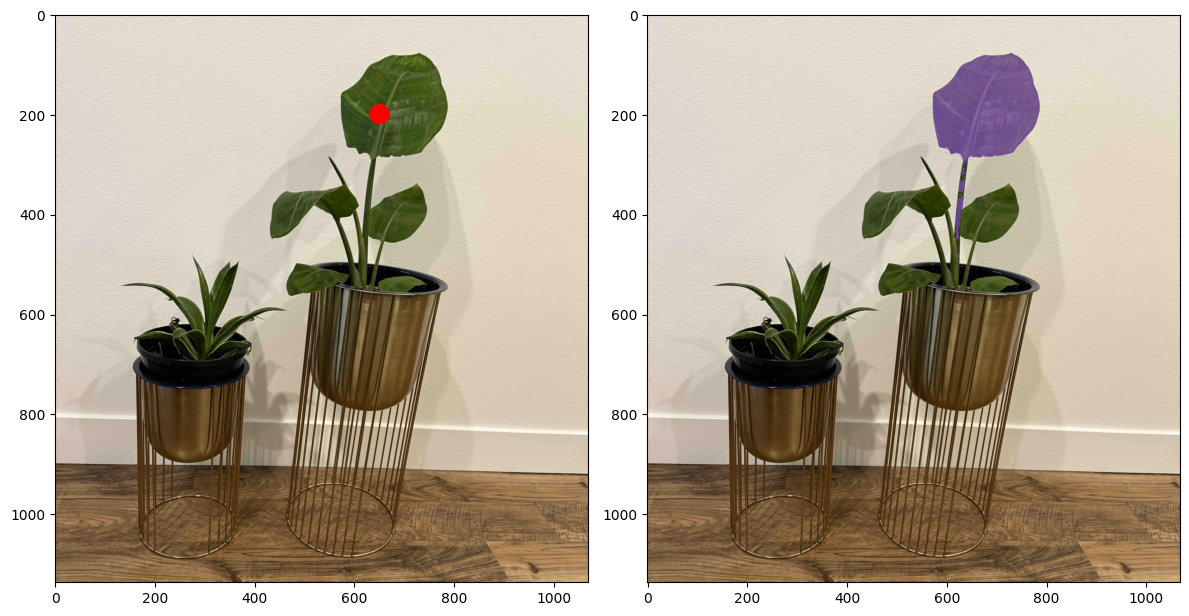

In [6]:
max_score_idx = np.argmax(scores)
max_score = np.array([scores[max_score_idx]])
max_score_mask = masks[max_score_idx][np.newaxis, :, :]

annot_img = visualize_mask(image.copy(), max_score_mask, max_score)

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(draw_points(image.copy(), input_points))
axes[1].imshow(annot_img)
plt.tight_layout()
plt.show()